# Milestone 2
## 2.1 Imports and data loading

In [1]:
import findspark
findspark.init()
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import to_date, dayofmonth, dayofweek, month, year, length, udf, greatest
import pyspark.sql.functions as f

import seaborn as sns

import pandas as pd

In [2]:
DATA_PATH = 'data/'
FILE_NAME_00 = 'amazon_reviews_us_Books_v1_00.tsv.gz'
FILE_NAME_01 = 'amazon_reviews_us_Books_v1_01.tsv.gz'
FILE_NAME_02 = 'amazon_reviews_us_Books_v1_02.tsv.gz'


In [29]:
data_00 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_00)
data_01 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_01)
data_02 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_02)

data = data_00.union(data_01).union(data_02)

Our data looks like this



|marketplace|customer_id|    review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|         review_body|review_date|
|-----------|-----------|-------------|----------|--------------|--------------------|----------------|-----------|-------------|-----------|----|-----------------|---------------|--------------------|-----------|
|         US|   25933450|RJOVP071AVAJO|0439873800|      84656342|There Was an Old ...|           Books|          5|            0|          0|   N|                Y|     Five Stars|I love it and so ...| 2015-08-31|
|         US|    1801372|R1ORGBETCDW3AI|1623953553|     729938122|      I Saw a Friend|           Books|          5|            0|          0|   N|                Y|Please buy "I Saw...|My wife and I ord...| 2015-08-31|


## 2.2 Analysis of some features

Before doing some real data analysis, we should look at some of the features and decide and they are worth keeping.

The `marketplace` won't be usefull since all the reviews are only for the US market.

**TODO** Talk about other columns



---
`verified_purchase` column : This might have an influence, since non-verified purchases won't be as reliable since poeple might not have actually bought the product. We will group all our data by `verified_purchase`, and compute look at the average rating.<br>
We also looked at only the newest data, since we wanted to verify that our conclusion is not influenced by time (the percentage of verified reviews increasing while the average rating increases).

In [18]:
verified_status = data.groupby('verified_purchase').agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating')) 
#verified_status = data.filter(year(to_date(data['review_date'], 'yyyy-MM-dd'))>=2015).groupby('verified_purchase').agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating')) 
_ = verified_status.persist()

We will convert it to a Pandas dataframe, an drop the NA row.

In [19]:
ver_pandas = verified_status.toPandas()
ver_pandas.dropna(inplace=True)

Since we have the mean and the standard deviation, we can compute the err_mean by applying the central limit theorem.

In [20]:
ver_pandas['err_mean']=1.96*ver_pandas['stddev_samp(star_rating)']/np.sqrt(ver_pandas['count(review_id)'])
ver_pandas.reset_index(inplace=True,drop=True)
ver_pandas

,verified_purchase,avg(star_rating),count(review_id),stddev_samp(star_rating),err_mean
0,Y,4.536860,2227454,0.959886,0.001261
1,N,4.345997,580276,1.140791,0.002935


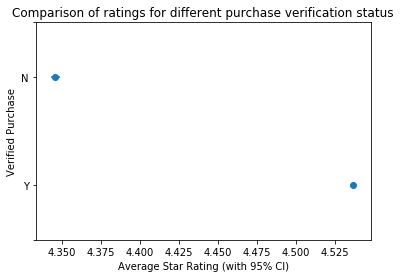

In [21]:
y = [1, 3]

plt.figure()
plt.errorbar(ver_pandas['avg(star_rating)'], y, xerr=ver_pandas['err_mean'], fmt = 'o')
plt.yticks((0, 1, 3, 4), ('', ver_pandas['verified_purchase'][0], ver_pandas['verified_purchase'][1],'')) 
plt.ylabel('Verified Purchase')
plt.xlabel('Average Star Rating (with 95% CI)')
plt.title('Comparison of ratings for different purchase verification status')
plt.show()

We can clearly see, with a 95% confidence interval, that the average rating is higher for verified reviews. **TODO WHY**. It would be good to ignore all unverified reviews, to have more reliable ratings. 

There is however a problem with that. By looking at the evolution of the number of reviews over the years (The code is done in part [2.4](##2.4 Analysis of Time Based Features)), we realized that in the earliest years there are almost no verified reviews. This is probably due to the fact that this fonctionality was added quite late, or that maybe it used to be harder to be a verified review. Hence, we decided, despite the difference of rating, to keep all reviews, in order to avoid losing so much data for the earlier years.

We didn't put the code that we used to keep the notebook well organized (but it is the same as in section [2.4](##2.4 Analysis of Time Based Features), one run with the complete data and once with only the verfied reviews). The only keep verified reviews, the following code was used :
```python
def keep_verified(data):
    return data.filter(data.verified_purchase == 'Y')
```

Here, you can see for all the reviews their average ratings and how many of them were written over the years.

![title](img/all.png)

And here, you can see for only the verified reviews their average ratings and how many of them were written over the years.

![title](img/verified.png) 

it is clear that a lot of data is mising in the 2000's if we limit ourselves to the verified reviews. From now on, we will use all the data

## 2.3 Rating vs vote counts & helpful votes

We first define a helper function that will group our data by product. For each product, we will have the average rating the number of reviews, the total number of votes and helpful votes, and the date of the earliest reviews. Not all of these atributes will be used now, we though it was better to have a single function instead of many slighly different functions.

In [5]:
def group_by_product(data):
    avg_stars = data.groupby('product_id', 'product_title').agg(f.avg('star_rating'), f.count('review_id'), f.sum('helpful_votes'),f.sum('total_votes'),f.min(to_date(data['review_date'], 'yyyy-MM-dd')), f.stddev('star_rating'))
    avg_stars.persist()
    avg_stars = avg_stars.withColumnRenamed('count(review_id)', 'n_reviews') \
                        .withColumnRenamed('sum(total_votes)', 'total_votes') \
                        .withColumnRenamed('sum(helpful_votes)', 'helpful_votes') \
                        .withColumnRenamed('avg(star_rating)', 'rating') \
                        .withColumnRenamed("min(to_date(`review_date`, 'yyyy-MM-dd'))", 'first_date') \
                        .withColumnRenamed('stddev_samp(star_rating)', 'std_rating')
    

    return avg_stars

We want to see if we have any relation between the helpful_votes ratio and the rating of a product, or between the number of reviews and the rating. 

In [30]:
avg_stars = group_by_product(data)
avg_stars.count()

3417300

Since we want to draw some plots, we have to convert our data to a pandas dataframe, However, we currently have too much data for pandas, so we decided to only keep reviews with more than 2 reviews. It is kind of an arbitrary number, but it is reasonable to assume that the average rating of products with a small amount of reviews might not be that reliable as an indication of the true quality of the product. If after some more advanced analysis we realized that those reviews might actually be important, we may to a subsample of the data instead, and use that for our plots.

In [46]:
main_avg_stars = avg_stars.where('n_reviews > 2')
main_avg_stars.count()

1292586

Our data bow looks like this 

|product_id|       product_title|            rating|n_reviews|helpful_votes|total_votes|first_date|         std_rating|
|----------|--------------------|------------------|---------|-------------|-----------|----------|-------------------|
|014241543X|           If I Stay| 4.154536390827517|     1003|       1441.0|     1842.0|2010-04-18| 1.1782488356812273|
|1250056608|Rough Justice: Si...|              4.25|       12|          7.0|        7.0|2015-02-05| 0.7537783614444091|
|0340909129|Do It Tomorrow an...|               4.6|       30|        439.0|      519.0|2006-08-14| 0.8136762043449723|

In [69]:
by_product = main_avg_stars.toPandas()

we will compute the ration of Helpful votes, which is more useful than the number of helpful votes.

In [70]:
by_product['ratio_helpful'] = by_product['helpful_votes'] / by_product['total_votes']

In [71]:
by_product = by_product.drop(columns=['helpful_votes', 'total_votes', 'first_date', 'std_rating'])

And our data now looks like this :

In [72]:
by_product.head(3)

,product_id,product_title,rating,n_reviews,ratio_helpful
0,014241543X,If I Stay,4.154536,1003,0.782302
1,1250056608,Rough Justice: Sinner's Tribe Motorcycle Club ...,4.250000,12,1.000000
2,0340909129,Do It Tomorrow and Other Secrets of Time Manag...,4.600000,30,0.845857


First, we will see how the rating depends on the helpful ratio. We will groupby `ratio_helpful`, which is cut into 50 bins, and compute the mean of each category

In [73]:
grouped_product_ratio = by_product.groupby([pd.cut(by_product['ratio_helpful'], bins=50, include_lowest=True)]).mean()
grouped_product_ratio.head(3)

,rating,n_reviews,ratio_helpful
ratio_helpful,,,
"(-0.002, 0.02]",4.341392,4.905736,0.000007
"(0.02, 0.04]",3.996099,6.875000,0.032728
"(0.04, 0.06]",4.062930,7.057269,0.051445


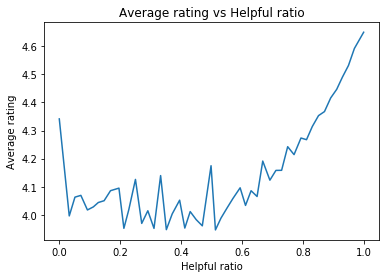

In [74]:
plt.plot(grouped_product_ratio['ratio_helpful'], grouped_product_ratio['rating'])
plt.xlabel('Helpful ratio')
plt.ylabel('Average rating')
plt.title('Average rating vs Helpful ratio')
plt.show()

**COMMENTS .......**


The higher noise for products with a low helpful ratio can be explained by the fact that there is way less data than for high ratios. This can be seen more clearly if we do a historigram of the disrtibution

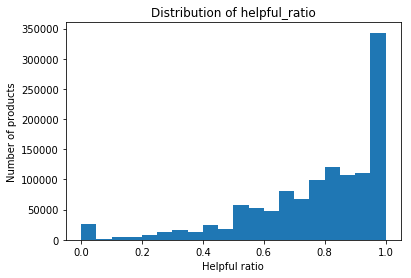

In [106]:
by_product['ratio_helpful'].plot.hist(20)
plt.xlabel("Helpful ratio")
plt.ylabel("Number of products")
plt.title("Distribution of helpful_ratio")
plt.show()

**COMMENTS about plot**

Now, we will plot the average rating compared to the number of reviews. We group on the number of reviews, but this time we use logarithmic bins for a nicer plot.

In [107]:
grouped_product_n_reviews = by_product.groupby([pd.cut(by_product['n_reviews'], bins=np.logspace(1, 3), include_lowest=True)]).mean()
grouped_product_n_reviews.head(3)

,rating,n_reviews,ratio_helpful
n_reviews,,,
"(9.999, 10.985]",4.369884,10.000000,0.776885
"(10.985, 12.068]",4.358492,11.459142,0.773810
"(12.068, 13.257]",4.355776,13.000000,0.771614


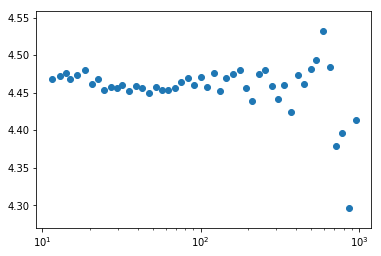

In [61]:
plt.scatter(grouped_product_n_reviews['n_reviews'], grouped_product_n_reviews['rating'])
plt.xscale('log')
plt.xlabel('Number of reviews')
plt.ylabel('Average rating')
plt.title('Average rating vs Helpful ratio')
plt.show()

**COMMENTS ........**

One again, the higher noise for products with a high number of reviews can be explained by the fact that there is way less data than for products with ltos of reviews. This can also be seen more clearly if we do an historigram.

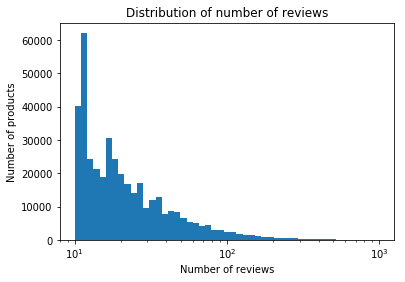

In [113]:
by_product['n_reviews'].plot.hist(bins=np.logspace(1,3))
plt.xlabel("Number of reviews")
plt.ylabel("Number of products")
plt.xscale('log')
plt.title("Distribution of number of reviews")
plt.show()

**COMMENTS about plot**

## 2.4 Analysis of Time Based Features

Here, we will try to see if the moment the review was posted has any influence. We will compare the data against the average rating, and the number of ratings. For the date, we will look at the year, the month, the day of the month and the day of the week.

We create a single function, that will take the data and the 'type of time', and plot two graphs, one with the average rating, and one with the number of ratings. For the average graph, we will also plot a 95% condidence interval on the mean, using the central limit theorem.

In [26]:
def get_time_analysis(data, time_name):
    time_types = {'month' : month('date'), 'year' : year('date'), 'dayofweek' : dayofweek('date'), 'dayofmonth' : dayofmonth('date')}
    group_function = time_types[time_name]
    
    # Groupby the time type, aggregate usefull columns, and sort by time
    data_bytime = data.groupby(group_function).agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating')).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('stddev_samp(star_ratinng)', 'std_rating').withColumnRenamed(time_name + '(date)', time_name)
    data_bytime_sorted = data_bytime.sort(time_name)
    
    by_time_pd = data_bytime_sorted.toPandas()
    
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    
    # First plot the average rating with it's condidence interval
    ax1.plot(by_time_pd[time_name], by_time_pd['rating'])
    ax1.fill_between(by_time_pd[time_name], by_time_pd['rating'] - 1.96 * by_time_pd['stddev_samp(star_rating)'] / np.sqrt(by_time_pd['count(review_id)']), \
                                            by_time_pd['rating'] + 1.96 * by_time_pd['stddev_samp(star_rating)'] / np.sqrt(by_time_pd['count(review_id)']), alpha=0.5)
    ax1.set_xlabel(time_name)
    ax1.set_ylabel('Average Rating')
    ax1.set_title('Avergage Rating vs ' + time_name)
    
    ax2.plot(by_time_pd[time_name], by_time_pd['count(review_id)'])
    ax2.set_xlabel(time_name)
    ax2.set_ylabel('Number of reviews')
    ax2.set_title('Number of reviews vs ' + time_name)
    plt.show()
    

We will give this function a table that has a rating and a review date as its columns

In [25]:
by_time = data.select(data['star_rating'],to_date(data['review_date'], 'yyyy-MM-dd').alias('date'), data['review_id'])
_ = by_time.persist()

Let's run it on different "types of time"

In [ ]:
get_time_analysis(by_time, 'month')

**COMMENTS**

In [ ]:
get_time_analysis(by_time, 'year')

**COMMENTS**

In [ ]:
get_time_analysis(by_time, 'dayofweek')

**COMMENTS**

In [ ]:
get_time_analysis(by_time, 'dayofmonth')

**COMMENTS**

## 2.5 Text analysis

In [146]:
div_by_10 = udf(lambda x : 0 if x is None else 1*int(x / 10))
div_by_100 = udf(lambda x : 0 if x is None else 10*int(x / 100))
by_review_length = data.select(data['star_rating'], \
                               div_by_10(length(data['review_headline'])).alias('title_length'), \
                               div_by_100(length(data['review_body'])).alias('body_length'), \
                                      data['review_id'])
by_review_length.persist()

DataFrame[star_rating: string, title_length: string, body_length: string, review_id: string]

In [147]:
by_review_length.show()

+-----------+------------+-----------+--------------+
|star_rating|title_length|body_length|     review_id|
+-----------+------------+-----------+--------------+
|          5|           1|          0| RJOVP071AVAJO|
|          5|           6|         30|R1ORGBETCDW3AI|
|          5|           1|          0| R7TNRFQAOUTX5|
|          5|           1|          0|R2GANXKDIFZ6OI|
|          5|           1|          0|R2NYB6C3R8LVN6|
|          2|           3|        150|R13U5PBJI1H94K|
|          5|           5|         70|R1H8UVH990F8VE|
|          5|           1|          0|R2MC0N30WZMRQ5|
|          5|           1|          0| R2NO2HXK16Y4J|
|          5|           1|          0|R245YIAVJK82ZL|
|          5|           1|          0| RFBMLBWQOZ1UM|
|          5|           3|         10| RHE1FEWV3KTQH|
|          5|           1|          0|R2BB9U7PHO7ETO|
|          4|           1|          0|R28XJJP754GYXO|
|          3|           7|         20|R2G519UREHRO8M|
|          5|           1|  

In [148]:

by_title_length = by_review_length.where('title_length < 300').groupby('title_length').agg({'star_rating':'avg', 'review_id':'count'}).\
                    withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_title_length.persist()

DataFrame[title_length: string, count: bigint, rating: double]

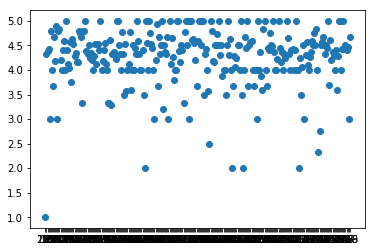

In [149]:
by_title_length_pd = by_title_length.toPandas()
by_title_length_pd
plt.scatter(by_title_length_pd['title_length'], by_title_length_pd['rating'])

In [35]:
by_body_length = by_review_length.groupby('body_length').agg({'star_rating':'avg', 'review_id':'count'}) \
                    .withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_body_length.persist()

DataFrame[body_length: string, count: bigint, rating: double]

In [ ]:
by_body_length.count()

In [ ]:
by_body_length_pd = by_body_length.toPandas()
by_body_length_pd
plt.plot(by_body_length_pd['body_length'], by_body_length_pd['count'])

## 2.6 Comparaison betwen countries

In this part, we want to see if there are any differences between the way people rate articles in differents countries. 

To be able to correcly compare ratings between countries, we will have to limit our dataset to products that are available in both regions. Moreover, we will only keep reviews given during the same time period, since we saw earlier that the year of the review had quite a big impact on the rating. 

> e.g. If for a given article we have reviews from 2001 to 2015 in the US, but only from 2005 to 2015 in the UK, we will discard all reviews in the us before 2005.

We will first do pairwise comparaisons, since it is the way we will have the most common data. We might also do a comparaison between all 5 available countries, but the remaining number of reviews might be limited.

For milestone 2, we will only study the difference between the US and UK, but the process will be the same for other pairs of countries.

---

First, we will open the datasets, as done earlier in this notebook

In [6]:
FILE_NAME_US = 'amazon_reviews_multilingual_US_v1_00.tsv.gz'
FILE_NAME_UK = 'amazon_reviews_multilingual_UK_v1_00.tsv.gz'

In [55]:
data_us = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_US)
data_uk = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_UK)
data_us = keep_verified(data_us)
data_uk = keep_verified(data_uk)

WIll we use again the group_by_product function from earlier, which will limit the data to one entry per product, and also give us the date of the first review for a given product

In [56]:
avg_us = group_by_product(data_us)
avg_uk = group_by_product(data_uk)

_ = avg_us.persist()
_ = avg_uk.persist()

# To be able to differenciate columns after a later join
us = avg_us.alias("us")
uk = avg_uk.alias("uk")

We can join the products from US and UK, with an inner join, so we only have common products

In [59]:
us_uk = us.join(uk, f.col('us.product_id') == f.col('uk.product_id'))

We can this here some of the entries of the us_uk table, were the left-hand side columns correspond to the US data, and the right-hand side columns to the UK data

|product_id|       product_title|           rating|n_reviews|helpful_votes|total_votes|first_date|        std_rating|product_id|       product_title|rating|n_reviews|helpful_votes|total_votes|first_date|       std_rating|
|----------|--------------------|-----------------|---------|-------------|-----------|----------|------------------|----------|--------------------|------|---------|-------------|-----------|----------|------------------|
|0099428385|I Don't Know How ...|4.666666666666667|        3|          2.0|        3.0|2011-05-02|0.5773502691896258|0099428385|I Don't Know How ...|4.454545454545454|       11|         12.0|       19.0|2009-09-04|0.8201995322647243|
|0141038225|Antifragile: Thin...|4.666666666666667|        3|          2.0|        3.0|2013-09-30|0.5773502691896258|0141038225|Antifragile: Thin...|              3.5|       14|         16.0|       26.0|2013-11-28|1.5566235649883122|
|0241951461|Penguin Essential...|              4.0|        3|          1.0|        5.0|2014-09-06|               1.0|0241951461|My Family and Oth...|4.333333333333333|        3|          1.0|       14.0|2012-12-03|1.1547005383792517|


We will use this table to get for each product the earliest date reviews were available in both countries 

In [62]:
latest_date = us_uk.select(f.col('us.product_id'),greatest(f.col('us.first_date'), f.col('uk.first_date'))) \
                        .withColumnRenamed("product_id", "id").withColumnRenamed("greatest(us.first_date, uk.first_date)", 'latest_date')

Again, here is an excerpt of the `latest_date` table, where `latest_date` is the date starting when the product `id` had received reviews in both countries

|        id|latest_date|
|----------|-----------|
|B00000IQW3| 2007-07-26|
|B00000IMCW| 2015-01-08|


We can now, for the US, and the UK, only keep reviews that were writen when the article was available in both countries

In [63]:
us_common_with_date = data_us.join(latest_date, data_us['product_id'] == latest_date['id'])
us_common_reviews = us_common_with_date.where('review_date >= latest_date')
_ = us_common_reviews.persist()

uk_common_with_date = data_uk.join(latest_date, data_uk['product_id'] == latest_date['id'])
uk_common_reviews = uk_common_with_date.where('review_date >= latest_date')
_ = uk_common_reviews.persist()

And now that we have reduced our dataset to only reviews of articles that are common between the uk and us, and for the same time period, we can get some statistics for each product

In [67]:
common_us_avg = group_by_product(us_common_reviews)
common_uk_avg = group_by_product(uk_common_reviews)

Here is an excerpt of the `common_us_avg` table

|product_id|       product_title|           rating|n_reviews|helpful_votes|total_votes|first_date|        std_rating|
|----------|--------------------|-----------------|---------|-------------|-----------|----------|------------------|
|0099428385|I Don't Know How ...| 4.666666666666667|        3|          2.0|        3.0|2011-05-02| 0.5773502691896258|
|0141038225|Antifragile: Thin...|               4.5|        2|          1.0|        1.0|2014-01-15| 0.7071067811865476|
|0241951461|Penguin Essential...|               4.0|        3|          1.0|        5.0|2014-09-06|                1.0|
|0385394233|Lean In: Women, W...| 4.454545454545454|       22|          4.0|       10.0|2014-01-03| 0.8578640544577771|

Here is an excerpt of the `common_uk_avg` table

|product_id|       product_title|           rating|n_reviews|helpful_votes|total_votes|first_date|        std_rating|
|----------|--------------------|-----------------|---------|-------------|-----------|----------|------------------|
|0099428385|I Don't Know How ...| 4.444444444444445|        9|          3.0|        6.0|2011-12-19|  0.881917103688197|
|0141038225|Antifragile: Thin...|               3.5|       14|         16.0|       26.0|2013-11-28| 1.5566235649883122|
|0385394233|Lean in: Women, W...|               5.0|        1|          0.0|        0.0|2013-12-24|                NaN|
|0553505416|Die Trying: (Jack...| 4.705882352941177|       17|          7.0|       10.0|2011-12-23| 0.9851843661437779|

Now that our data has been cleaned, we can try and see if there is a difference between the ratings from the US and the UK. 

In [68]:
us_pd = common_us_avg.toPandas()
uk_pd = common_uk_avg.toPandas()

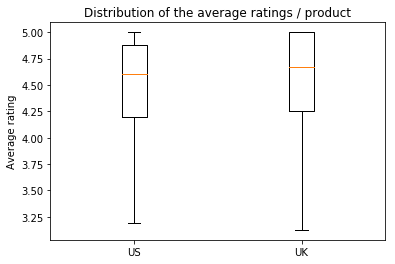

In [69]:
plt.boxplot([us_pd['rating'], uk_pd['rating']], 0, sym='',autorange=True, labels=['US', 'UK'])
plt.title('Distribution of the average ratings / product')
plt.ylabel('Average rating')
plt.show()

We see that the median average rating is lower in the US than in the UK, but `TO COMPLETE`

## 2.7 Herding behavior

Do we have enough data to perform this analysis ?

For common articles in every countries, get the first review and compare it to the average review. Correct the bias due to the difference between countries.